In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from environment.env import POMDPDeformedGridworld
import numpy as np 
import torch

In [2]:
import numpy as np

def generate_random_matrix(diagonal_range=(0.4, 1), off_diagonal_range=(-0.2, 0.2)):
    """
    Generate a random 2x2 matrix with diagonal elements in the specified range
    and off-diagonal elements in the specified range.

    Args:
        diagonal_range (tuple): Range for diagonal elements (min, max).
        off_diagonal_range (tuple): Range for off-diagonal elements (min, max).

    Returns:
        np.ndarray: A 2x2 matrix satisfying the conditions.
    """
    # Diagonal elements
    diagonal_elements = np.random.uniform(*diagonal_range, 2)

    # Off-diagonal elements
    off_diagonal_elements = np.random.uniform(*off_diagonal_range, 2)

    # Construct the 2x2 matrix
    matrix = np.array([
        [diagonal_elements[0], off_diagonal_elements[0]],
        [off_diagonal_elements[1], diagonal_elements[1]]
    ])
    
    return matrix.tolist()

def generate_random_pos():
    """random position in the environment
    reutnr an array of 2 elements
    each ranges from -.2 to 1.2"""
    return np.random.uniform(-.2, 1.2, 2).tolist()

generate_random_pos()

[0.338198683932956, 1.081375051031876]

# create dataset

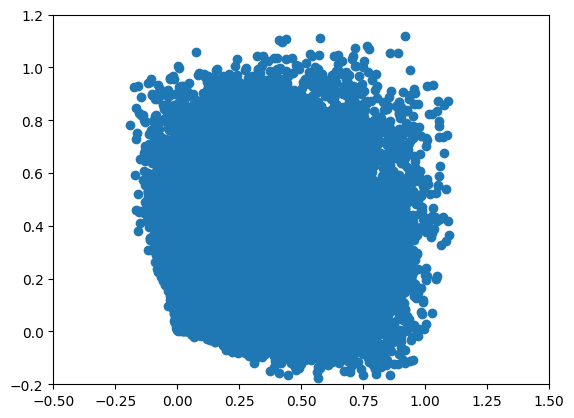

In [3]:
env = POMDPDeformedGridworld()

# generate positions and plot them using matplotlib
import matplotlib.pyplot as plt

positions = [env.reset()[0]['pos'].tolist() for _ in range(20000)]
positions = np.array(positions)

plt.scatter(positions[:, 0], positions[:, 1])
plt.xlim(-.5, 1.5)
plt.ylim(-.2, 1.2)
plt.show()


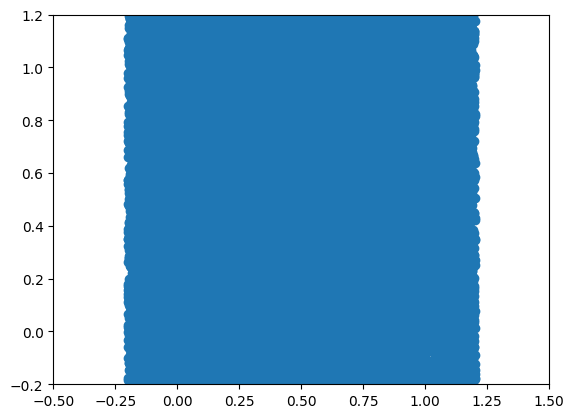

In [5]:
# generate positions and plot them using matplotlib
import matplotlib.pyplot as plt

positions = [generate_random_pos() for _ in range(20000)]
positions = np.array(positions)

plt.scatter(positions[:, 0], positions[:, 1])
plt.xlim(-.5, 1.5)
plt.ylim(-.2, 1.2)
plt.show()


In [5]:
## SINGLE OBSERVATION
from tqdm import trange
env = POMDPDeformedGridworld()

num_positions = 5000
num_defomations = 5000
dataset = []

for i in trange(num_positions):
    matrix = generate_random_matrix(diagonal_range=(0, 2), off_diagonal_range=(-0.5, 0.5))  
    for _ in range(num_defomations):
        pos = generate_random_pos()
        obs = env.batchedobserve(pos, matrix)
        
        datapoint = {"pos":       pos,
        
                    "theta":      matrix,
                    "deform_obs": obs,
                }
        dataset.append(datapoint)


100%|██████████| 5000/5000 [02:28<00:00, 33.72it/s]


In [14]:
len(dataset)

25000000

In [14]:
# save dataset
import pickle

with open("dataset_cardinal.pkl", "wb") as f:
    pickle.dump(dataset, f)

: 

# train


In [2]:
import pickle
# lod dataset
with open("dataset0.pkl", "rb") as f:
    dataset0 = pickle.load(f)

print(len(dataset0))

25000000


In [6]:
dataset0[0]

{'pos': [1.187128849826397, 0.16141330171899854],
 'theta': [[0.8633541558021538, -0.16384444483009025],
  [-0.04366285130630887, 0.6862497751454542]],
 'deform_obs': [0.0]}

In [ ]:
import pickle
# lod dataset
with open("dataset1.pkl", "rb") as f:
    dataset1 = pickle.load(f)

print(len(dataset1))

In [ ]:
full_dataset = dataset0 + dataset1

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, data_list):
        """
        Args:
            data_list (list): List of dictionaries containing 'o', 'theta', 'qpos', and 'qpos_new'.
        """
        self.data_list = data_list

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.data_list)

    def __getitem__(self, idx):
        """
        Retrieve one sample of data by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            A dictionary with inputs and expected outputs as tensors.
        """
        # Extract the dictionary for the given index
        data = self.data_list[idx]
        
        # Convert data to PyTorch tensors
        theta = torch.tensor(data['theta'], dtype=torch.float32).flatten()
        o_new = torch.tensor(data['deform_obs'], dtype=torch.float32)
        pos = torch.tensor(data['pos'], dtype=torch.float32)      
        

        # Inputs: qpos_new, o, theta
        inputs = {
            'theta': theta,
            'pos': pos
        }
        
        # Output: qpos_new
        target = {
             "deform_obs": o_new        
             }
        
        return inputs, target


# Instantiate the dataset
custom_dataset = CustomDataset(dataset0)

# Create a DataLoader
data_loader = DataLoader(custom_dataset, batch_size=1024, shuffle=True)


In [19]:
for inputs, target in data_loader:
    print((inputs['pos'].shape,inputs['theta'].shape, target['deform_obs'].shape))
    break


(torch.Size([1024, 2]), torch.Size([1024, 4]), torch.Size([1024, 1]))


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.f1 = nn.Linear(6, 128)
        self.f2 = nn.Linear(128, 128)
        self.f3 = nn.Linear(128, 128)
        self.f4 = nn.Linear(128, 1)
        
    def forward(self, pos,theta):
        x = torch.cat([pos,theta], dim=1)
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = F.relu(self.f3(x))
        x = F.sigmoid(self.f4(x))
        return x

# Instantiate the model
model = NN()

# Check the output size
# Iterate through the DataLoader
for inputs, target in data_loader:
    print(model(inputs['pos'],inputs['theta']).shape)
    break




torch.Size([1024, 1])


In [25]:
# train network 
import torch.optim as optim
from tqdm.notebook import tqdm
# Instantiate the model
model = NN()


# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model in training mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()
model.compile()



In [26]:
# tqdm progress bar
pbar = tqdm(total=len(data_loader),desc="Training")
pbar.refresh()
pbar.reset()

# Iterate through the DataLoader
for epoch in range(25):
    running_loss = 0.0
    pbar.set_description(f"Epoch {epoch}")
    for i, (inputs, target) in enumerate(data_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs['pos'].to(device).to(device),inputs['theta'].to(device))

        # Compute the loss
        loss = criterion(outputs, target['deform_obs'].to(device))

        # Backward pass
        running_loss += loss.item()
        loss.backward()

        # Update the weights
        optimizer.step()

        pbar.update(1)
    pbar.reset()
    print("runningLoss:", running_loss/len(data_loader))


Training:   0%|          | 0/24415 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
# save model
torch.save(model.state_dict(), "obs_model.pth")

In [ ]:
# filter target with obstacle
count = 0
for inputs, target in data_loader:
    count += torch.count_nonzero(target['obs'])


In [ ]:
len(dataset), count.item(), count.item()/len(dataset) 

(1000000, 121000, 0.121)

In [ ]:
count

tensor(121000)

In [ ]:
# test model
model.eval()
with torch.no_grad():
    for inputs, target in data_loader:
        outputs = model(inputs['pos'].to(device),inputs['deform_obs'].to(device),inputs['theta'].to(device))
        print(inputs)
        print(outputs)
        break

{'deform_obs': tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]), 'theta': tensor([[ 0.6069,  0.0460, -0.1410,  0.7324],
        [ 0.4951, -0.0290, -0.1900,  0.5352],
        [ 0.5310, -0.0502,  0.1989,  0.4344],
        ...,
        [ 0.5591, -0.1723,  0.1204,  0.5878],
        [ 0.9620,  0.1982, -0.0428,  0.7177],
        [ 0.4606, -0.0163,  0.0165,  0.8431]]), 'pos': tensor([[0.7033, 0.4231],
        [0.5368, 0.4076],
        [1.1467, 1.1071],
        ...,
        [0.4275, 1.1039],
        [1.0132, 1.0841],
        [0.0238, 1.0522]])}
tensor([[4.3709e-04],
        [4.6240e-01],
        [6.8391e-05],
        ...,
        [4.8210e-02],
        [1.5263e-03],
        [1.8719e-02]], device='cuda:0')


# eval

In [2]:
import pickle
# lod dataset
with open("dataset1.pkl", "rb") as f:
    dataset0 = pickle.load(f)

print(len(dataset0))

25000000


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.f1 = nn.Linear(6, 128)
        self.f2 = nn.Linear(128, 128)
        self.f3 = nn.Linear(128, 128)
        self.f4 = nn.Linear(128, 1)
        
    def forward(self, pos,theta):
        x = torch.cat([pos,theta], dim=1)
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = F.relu(self.f3(x))
        x = F.sigmoid(self.f4(x))
        return x

# Instantiate the model
model = NN()

model.load_state_dict(torch.load("obs_model_0.pth", weights_only=True))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

NN(
  (f1): Linear(in_features=6, out_features=128, bias=True)
  (f2): Linear(in_features=128, out_features=128, bias=True)
  (f3): Linear(in_features=128, out_features=128, bias=True)
  (f4): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, data_list):
        """
        Args:
            data_list (list): List of dictionaries containing 'o', 'theta', 'qpos', and 'qpos_new'.
        """
        self.data_list = data_list

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.data_list)

    def __getitem__(self, idx):
        """
        Retrieve one sample of data by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            A dictionary with inputs and expected outputs as tensors.
        """
        # Extract the dictionary for the given index
        data = self.data_list[idx]
        
        # Convert data to PyTorch tensors
        theta = torch.tensor(data['theta'], dtype=torch.float32).flatten()
        o_new = torch.tensor(data['deform_obs'], dtype=torch.float32)
        pos = torch.tensor(data['pos'], dtype=torch.float32)      
        

        # Inputs: qpos_new, o, theta
        inputs = {
            'theta': theta,
            'pos': pos
        }
        
        # Output: qpos_new
        target = {
             "deform_obs": o_new        
             }
        
        return inputs, target


# Instantiate the dataset
custom_dataset = CustomDataset(dataset0)

# Create a DataLoader
data_loader = DataLoader(custom_dataset, batch_size=1024, shuffle=True)


In [9]:
# test model
model.eval()
with torch.no_grad():
    for inputs, target in data_loader:
        outputs = model(inputs['pos'].to(device),inputs['theta'].to(device))
        print(inputs)
        print(outputs)
        break

{'theta': tensor([[ 0.4053, -0.1912,  0.0558,  0.6933],
        [ 0.8898, -0.0317,  0.0568,  0.9900],
        [ 0.5336, -0.0433,  0.1790,  0.4546],
        ...,
        [ 0.9264,  0.1716, -0.1404,  0.8411],
        [ 0.4391,  0.1867, -0.1994,  0.4870],
        [ 0.9450,  0.0402,  0.1066,  0.8249]]), 'pos': tensor([[-0.1493, -0.0461],
        [ 0.7620,  0.2586],
        [ 0.7172,  0.6116],
        ...,
        [-0.0668,  0.7490],
        [ 0.7191,  0.8728],
        [ 0.1038,  0.4401]])}
tensor([[0.0000e+00],
        [2.7087e-26],
        [0.0000e+00],
        ...,
        [0.0000e+00],
        [0.0000e+00],
        [5.2236e-23]], device='cuda:0')


## formal evaluation

In [8]:
model.eval()
criterion = nn.BCELoss()
running_loss = 0.0
with torch.no_grad():
    for i, (inputs, target) in enumerate(data_loader):
        # Zero the parameter gradients
        
        # Forward pass
        outputs = model(inputs['pos'].to(device).to(device),inputs['theta'].to(device))

        # Compute the loss
        loss = criterion(outputs, target['deform_obs'].to(device))

        # Backward pass
        running_loss += loss.item()

        if i > 200:
            print("runningLoss:", running_loss/i)
            break


runningLoss: 0.009032194635863253


## visual eval

In [4]:
env = POMDPDeformedGridworld()
env.reset()
# env.set_deformation([0.5, 0.8],[0,0])

env.transformation_matrix


[[0.4454763319560482, -0.0607467615501435],
 [0.15969486124461996, 0.46654278803481963]]

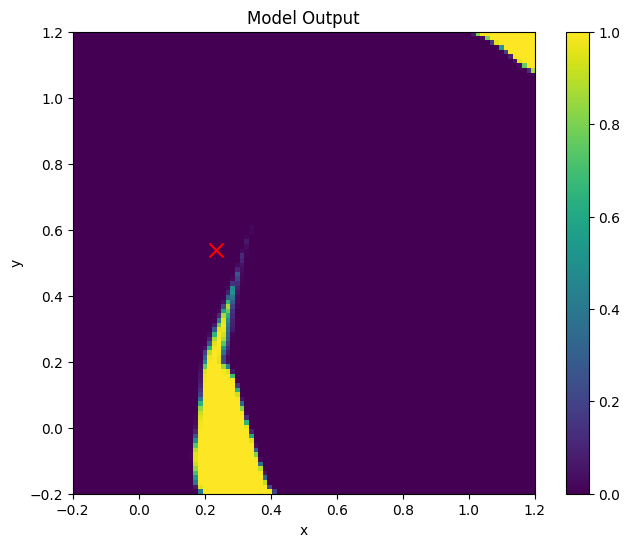

In [6]:
# create a two dimensional plot, for each position in the environment, plot the result of obs_model
import numpy as np
import matplotlib.pyplot as plt

# Generate a grid of positions
x = np.linspace(-0.2, 1.2, 100)
y = np.linspace(-0.2, 1.2, 100)
xx, yy = np.meshgrid(x, y)
positions = np.column_stack([xx.ravel(), yy.ravel()])
positions = torch.tensor(positions, dtype=torch.float32)

# consderate just one theta
theta = torch.tensor(env.transformation_matrix, dtype=torch.float32).flatten()
theta = torch.tensor( [ 1.4882014 , 1.6038883, -1.7425169 , 4.7037725])
# Compute the model output
model.eval()
with torch.no_grad():
    outputs = model(positions.to(device), theta.repeat(positions.shape[0],1).to(device)).cpu().numpy().reshape(xx.shape)

# Plot the model output
plt.figure(figsize=(8, 6))
plt.imshow(outputs, extent=(-0.2, 1.2, -0.2, 1.2), origin='lower', cmap='viridis')
plt.colorbar()
plt.scatter(*env.state, color='red', marker='x', s=100)
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Output')
plt.show()


In [20]:
env.render()

(None, None, None, None, None)

In [46]:
stretch = np.linspace(-0.2, 1.2, 100)
shear = np.linspace(-0.2, .2, 100)
xa,xb,ya,yb = np.meshgrid(stretch, stretch, shear, shear)
positions = np.column_stack([xa.ravel(), ya.ravel(),yb.ravel(),xb.ravel()])
positions = torch.tensor(positions, dtype=torch.float32)
positions

tensor([[-0.2000, -0.2000, -0.2000, -0.2000],
        [-0.2000, -0.2000, -0.1960, -0.2000],
        [-0.2000, -0.2000, -0.1919, -0.2000],
        ...,
        [ 1.2000,  0.2000,  0.1919,  1.2000],
        [ 1.2000,  0.2000,  0.1960,  1.2000],
        [ 1.2000,  0.2000,  0.2000,  1.2000]])

In [47]:
positions.shape

torch.Size([100000000, 4])

: 

# check function

In [5]:
env = POMDPDeformedGridworld()
env.reset()
env.render()
print(env.transformation_matrix)


[[0.5247014424879411, 0.021347489018892635], [0.10498478536555922, 0.9971405313629368]]


In [6]:
env.batchedobserve(env.state, env.transformation_matrix)

[0.0]

In [8]:
previous_obs = env.batchedobserve(env.state, env.transformation_matrix)
while True:
    env.render()
    next_obs = env.batchedobserve(env.state, env.transformation_matrix)
    if previous_obs != next_obs:
        print(env.batchedobserve(env.state, env.transformation_matrix))
        previous_obs = next_obs

[0.0]
[1.0]
[0.0]
[1.0]
[0.0]
[1.0]
[0.0]
[1.0]
[0.0]
[1.0]
[0.0]
[1.0]
[0.0]
[1.0]
[0.0]
[1.0]


error: display Surface quit

# cardinal

In [3]:
## CARDINAL COLLISIONS
from tqdm import trange
env = POMDPDeformedGridworld()

num_positions = 5000
num_defomations = 5000
dataset = []

for i in trange(num_positions):
    matrix = generate_random_matrix(diagonal_range=(0, 2), off_diagonal_range=(-0.5, 0.5))  
    env.set_deformation([matrix[0][0],matrix[1][1]], [matrix[0][1],matrix[1][0]])
    for _ in range(num_defomations):
        pos = generate_random_pos()
        obs = env.is_collision_cardinal(pos)
        
        datapoint = {"pos":       pos,
        
                    "theta":      matrix,
                    "deform_obs": obs,
                }
        dataset.append(datapoint)


100%|██████████| 5000/5000 [02:26<00:00, 34.11it/s]


In [4]:
# save dataset
import pickle

with open("dataset_cardinal.pkl", "wb") as f:
    pickle.dump(dataset, f)

In [7]:
import pickle
# lod dataset
with open("dataset_cardinal.pkl", "rb") as f:
    dataset0 = pickle.load(f)

print(len(dataset0))

25000000


In [9]:
dataset0[0]

{'pos': [0.11224888732835697, 0.9070039035256232],
 'theta': [[0.966830964985683, -0.026059125060731714],
  [0.2240136709811823, 1.5680173833718691]],
 'deform_obs': [True, False, False, False]}

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, data_list):
        """
        Args:
            data_list (list): List of dictionaries containing 'o', 'theta', 'qpos', and 'qpos_new'.
        """
        self.data_list = data_list

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.data_list)

    def __getitem__(self, idx):
        """
        Retrieve one sample of data by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            A dictionary with inputs and expected outputs as tensors.
        """
        # Extract the dictionary for the given index
        data = self.data_list[idx]
        
        # Convert data to PyTorch tensors
        theta = torch.tensor(data['theta'], dtype=torch.float32).flatten()
        o_new = torch.tensor(data['deform_obs'], dtype=torch.float32)
        pos = torch.tensor(data['pos'], dtype=torch.float32)      
        

        # Inputs: qpos_new, o, theta
        inputs = {
            'theta': theta,
            'pos': pos
        }
        
        # Output: qpos_new
        target = {
             "deform_obs": o_new        
             }
        
        return inputs, target


# Instantiate the dataset
custom_dataset = CustomDataset(dataset0)

# Create a DataLoader
data_loader = DataLoader(custom_dataset, batch_size=1024, shuffle=True)


In [11]:
for inputs, target in data_loader:
    print((inputs['pos'].shape,inputs['theta'].shape, target['deform_obs'].shape))
    break


(torch.Size([1024, 2]), torch.Size([1024, 4]), torch.Size([1024, 4]))


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.f1 = nn.Linear(6, 128)
        self.f2 = nn.Linear(128, 128)
        self.f3 = nn.Linear(128, 128)
        self.f4 = nn.Linear(128, 4)
        
    def forward(self, pos,theta):
        x = torch.cat([pos,theta], dim=1)
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = F.relu(self.f3(x))
        x = F.sigmoid(self.f4(x))
        return x

# Instantiate the model
model = NN()

# Check the output size
# Iterate through the DataLoader
for inputs, target in data_loader:
    output = model(inputs['pos'],inputs['theta'])
    print(output[0], output.shape)
    break




tensor([0.5044, 0.4774, 0.5321, 0.5230], grad_fn=<SelectBackward0>) torch.Size([1024, 4])


In [15]:
# train network 
import torch.optim as optim
from tqdm.notebook import tqdm
# Instantiate the model
model = NN()


# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model in training mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model.to(device)
model.train()
model.compile()



/home/flaccagora/.miniconda3/envs/robogym/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
# tqdm progress bar
pbar = tqdm(total=len(data_loader),desc="Training")
pbar.refresh()
pbar.reset()

# Iterate through the DataLoader
for epoch in range(25):
    running_loss = 0.0
    pbar.set_description(f"Epoch {epoch}")
    for i, (inputs, target) in enumerate(data_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs['pos'].to(device).to(device),inputs['theta'].to(device))

        # Compute the loss
        loss = criterion(outputs, target['deform_obs'].to(device))

        # Backward pass
        running_loss += loss.item()
        loss.backward()

        # Update the weights
        optimizer.step()

        pbar.update(1)
    pbar.reset()
    print("runningLoss:", running_loss/len(data_loader))


Training:   0%|          | 0/24415 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# save model
torch.save(model.state_dict(), "obs_model.pth")